In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import tqdm
from sklearn.model_selection import cross_val_score, cross_validate
%matplotlib inline 
sns.set(style="ticks")

In [16]:
data = pd.read_csv('oec (1).csv', sep=',')

In [4]:
#размер датасета
data.shape

(239, 12)

In [5]:
data.head()

,PlanetIdentifier,PlanetaryMassJpt,RadiusJpt,PeriodDays,SemiMajorAxisAU,SurfaceTempK,DiscoveryYear,DistFromSunParsec,HostStarMassSlrMass,HostStarRadiusSlrRad,HostStarTempK,Type
0,Kepler-13 A b,46997.0,18629.00,1.76,0.03,2750.0,2011,530.0,26299.00,27030.00,7650,Hot Jupiter
1,KELT-7 b,46753.0,1.53,2.73,0.04,2048.0,2015,129.0,1.53,1.73,6789,Hot Jupiter
2,KOI-830 b,46388.0,44044.00,3.53,0.04,1070.0,2014,720.0,0.87,0.80,5150,Gas giant
3,CoRoT-20 b,45383.0,0.84,43870.00,0.09,1002.0,2011,1230.0,41640.00,43862.00,5880,Hot Jupiter
4,WASP-82 b,45292.0,24473.00,2.71,0.04,2190.0,2013,200.0,23012.00,43132.00,6490,Hot Jupiter


Обработка пропусков

In [6]:
# Колонки с пропусками
hcols_with_na = [c for c in data.columns if data[c].isnull().sum() > 0]
hcols_with_na

[]

Пропусков нет

In [7]:
data['Type'].unique()

array(['Hot Jupiter', 'Gas giant', 'Terrestrial'], dtype=object)

Кодирование категориальных данных

In [17]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
le.fit(data.PlanetIdentifier)
data['PlanetIdentifier']=le.transform(data.PlanetIdentifier)

In [18]:
le=LabelEncoder()
le.fit(data.Type)
data['Type']=le.transform(data.Type)

In [10]:
data.dtypes

PlanetIdentifier          int32
PlanetaryMassJpt        float64
RadiusJpt               float64
PeriodDays              float64
SemiMajorAxisAU         float64
SurfaceTempK            float64
DiscoveryYear             int64
DistFromSunParsec       float64
HostStarMassSlrMass     float64
HostStarRadiusSlrRad    float64
HostStarTempK             int64
Type                      int32
dtype: object

In [31]:

x = data.drop([data.columns[-1]], axis=1)

In [34]:
def arr_to_df(arr_scaled):
    res = pd.DataFrame(arr_scaled, columns=x.columns)
    return res

In [35]:
from sklearn.model_selection import train_test_split
# Разделим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(x, data['Type'],
                                                    test_size=0.3,
                                                    random_state=1)
# Преобразуем массивы в DataFrame
X_train_df = arr_to_df(X_train)
X_test_df = arr_to_df(X_test)

X_train_df.shape, X_test_df.shape, y_train.shape, y_test.shape

((167, 11), (72, 11), (167,), (72,))

In [36]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='white')
        plt.show()

In [37]:

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [39]:
us_clas_models_dict = {'LinR': LinearRegression(), 
                    'SVR': SVR(),
                    'KNN_5':KNeighborsRegressor(n_neighbors=5),
                    'Tree':DecisionTreeRegressor(random_state=1),
                    'GB': GradientBoostingRegressor(random_state=1),
                    'RF':RandomForestRegressor(n_estimators=50, random_state=1)}

In [40]:
us_data_list = [
    ('Original', X_train_df, X_test_df)
]

In [53]:
def test_models(clas_models_dict, X_train, X_test, y_train, y_test):
    
    logger = MetricLogger()
    
    for model_name, model in clas_models_dict.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        logger.add(model_name, 'Basic', mse)
            
    return logger

In [54]:
logger = test_models(us_clas_models_dict, X_train_df, X_test_df, y_train, y_test)

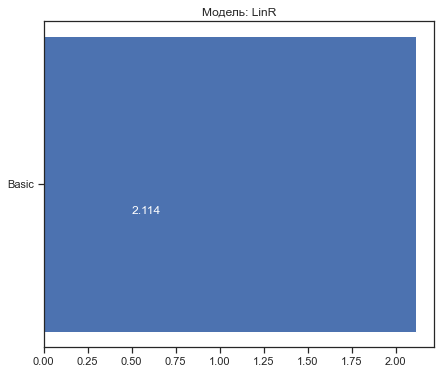

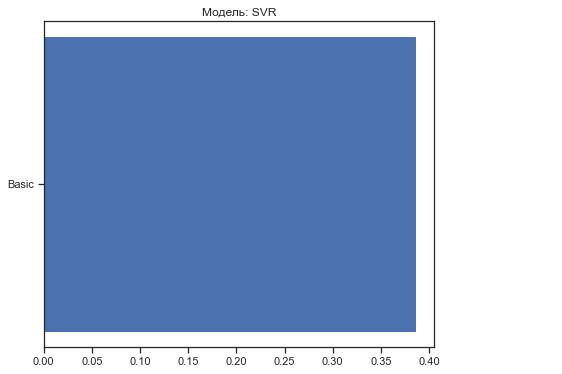

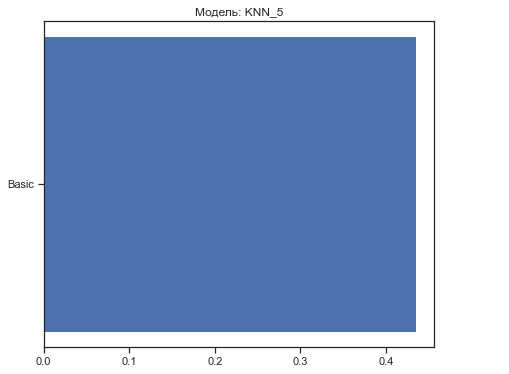

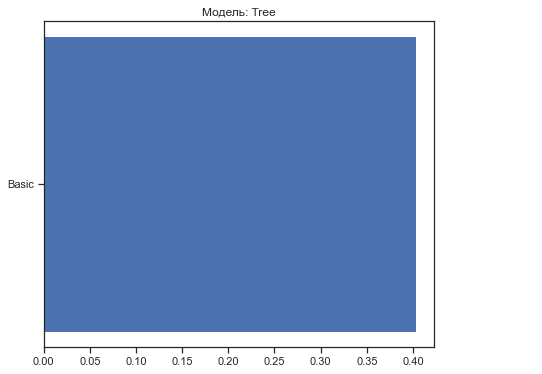

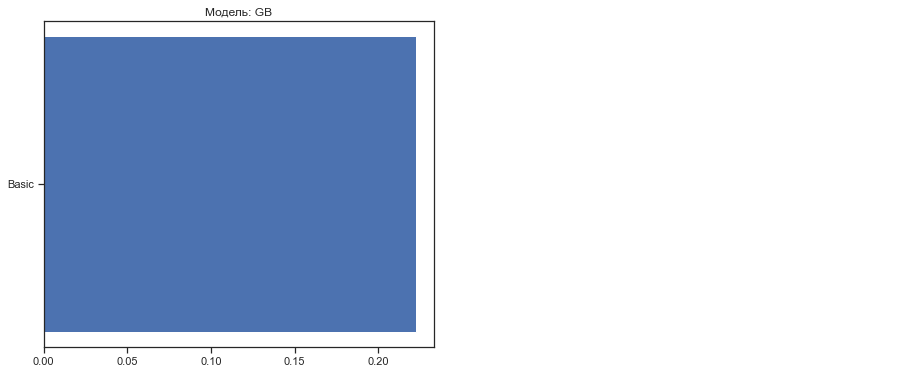

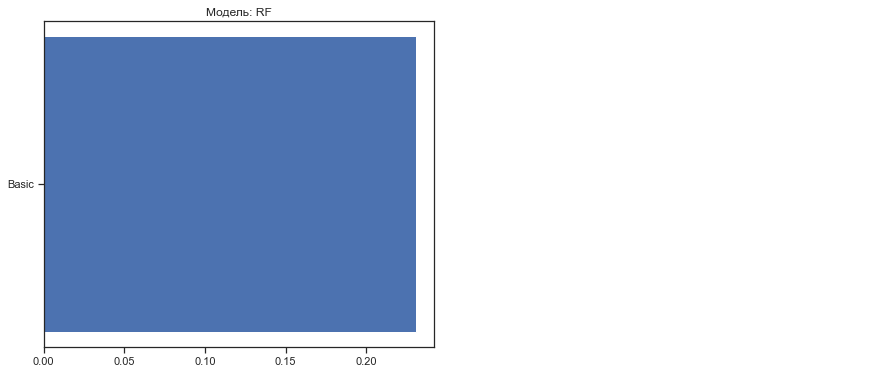

In [55]:
# Построим графики метрик качества модели
for model in us_clas_models_dict:
    logger.plot('Модель: ' + model, model, figsize=(7, 6))

In [1]:
from supervised.automl import AutoML

In [11]:
automl= AutoML()

In [12]:
automl.fit(data[data.columns[:-1]], data['Type'])

AutoML directory: AutoML_1
The task is multiclass_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline logloss 0.993422 trained in 0.26 seconds
2_DecisionTree logloss 0.732331 trained in 11.97 seconds
3_Linear logloss 0.773725 trained in 4.55 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost logloss 0.506169 trained in 4.82 seconds
5_Default_NeuralNetwork logloss 0.914246 trained in 0.47 seconds
6_Default_RandomForest logloss 0.508385 trained in 9.88 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.486537 trained in 0.12 seconds
AutoML fit time: 35.87 seconds


AutoML()

In [63]:
from scipy import stats
def diagnostic_plots(df, variable, title):
    fig, ax = plt.subplots(figsize=(10,7))
    # гистограмма
    plt.subplot(2, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(2, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    # ящик с усами
    plt.subplot(2, 2, 3)
    sns.violinplot(x=df[variable])    
    # ящик с усами
    plt.subplot(2, 2, 4)
    sns.boxplot(x=df[variable])  
    fig.suptitle(title)
    plt.show()

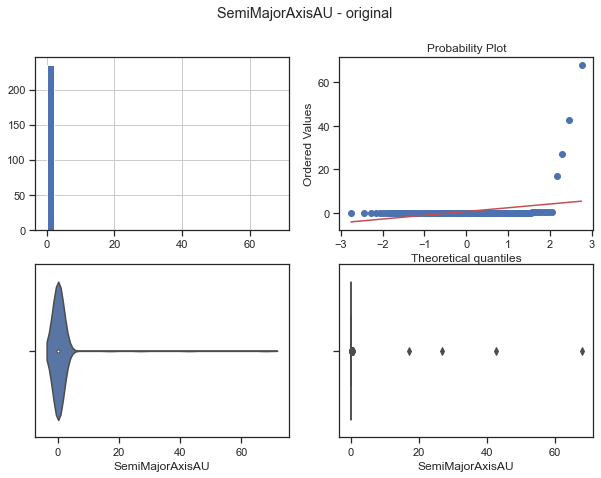

In [67]:
diagnostic_plots(data, 'SemiMajorAxisAU', 'SemiMajorAxisAU - original')

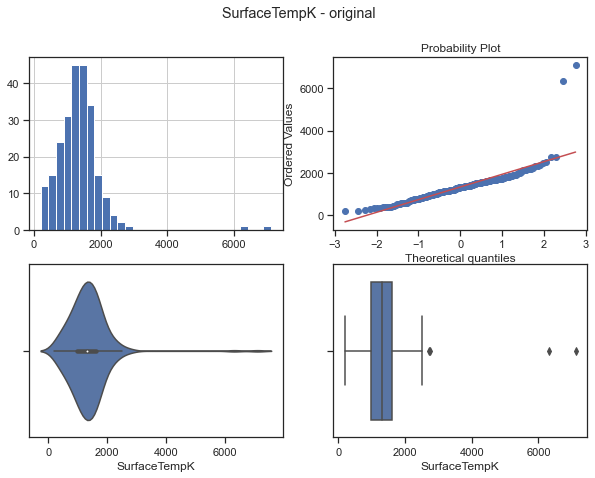

In [68]:
diagnostic_plots(data, 'SurfaceTempK', 'SurfaceTempK - original')

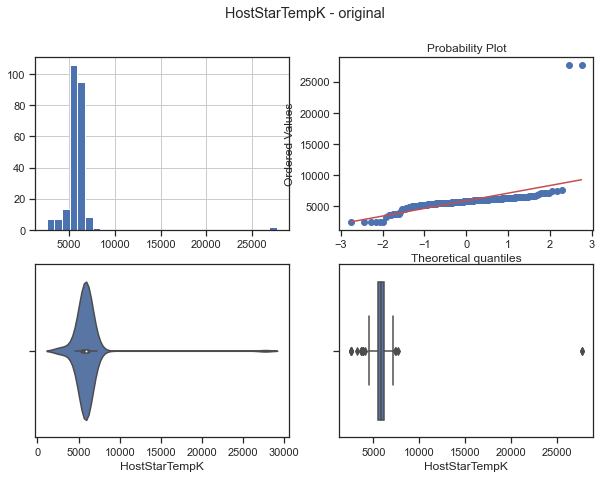

In [71]:
diagnostic_plots(data, 'HostStarTempK', 'HostStarTempK - original')

In [72]:
# Тип вычисления верхней и нижней границы выбросов
from enum import Enum
class OutlierBoundaryType(Enum):
    SIGMA = 1
    QUANTILE = 2
    IRQ = 3

In [73]:
# Функция вычисления верхней и нижней границы выбросов
def get_outlier_boundaries(df, col, outlier_boundary_type: OutlierBoundaryType):
    if outlier_boundary_type == OutlierBoundaryType.SIGMA:
        K1 = 3
        lower_boundary = df[col].mean() - (K1 * df[col].std())
        upper_boundary = df[col].mean() + (K1 * df[col].std())

    elif outlier_boundary_type == OutlierBoundaryType.QUANTILE:
        lower_boundary = df[col].quantile(0.05)
        upper_boundary = df[col].quantile(0.95)

    elif outlier_boundary_type == OutlierBoundaryType.IRQ:
        K2 = 1.5
        IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
        lower_boundary = df[col].quantile(0.25) - (K2 * IQR)
        upper_boundary = df[col].quantile(0.75) + (K2 * IQR)

    else:
        raise NameError('Unknown Outlier Boundary Type')
        
    return lower_boundary, upper_boundary 

In [74]:
x_col_list = ['HostStarTempK', 'DistFromSunParsec', 'SemiMajorAxisAU', 'SurfaceTempK']

In [81]:
data1=data

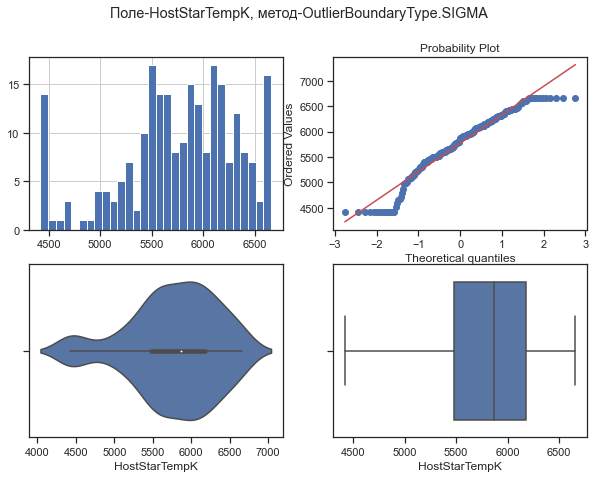

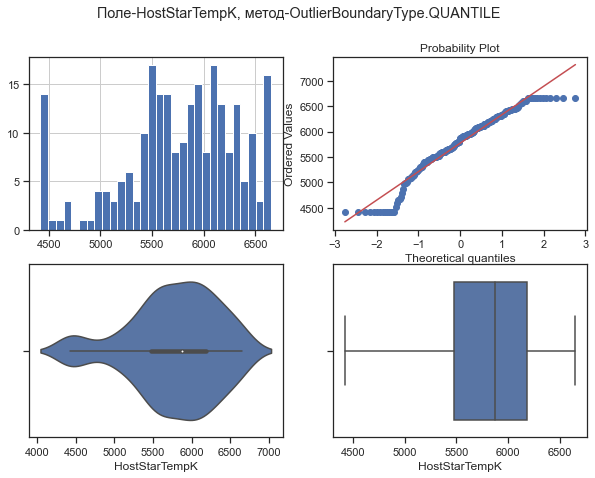

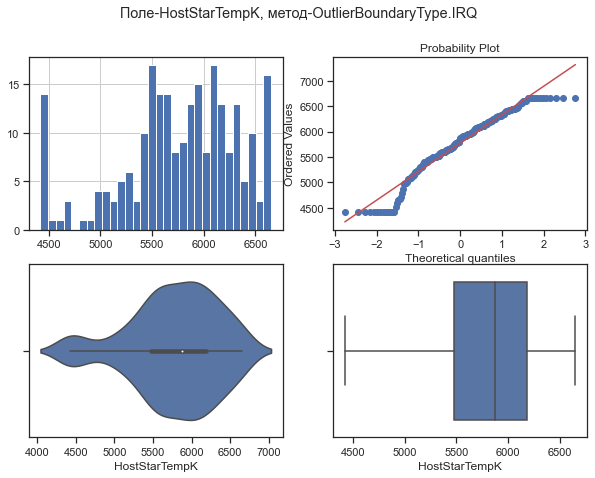

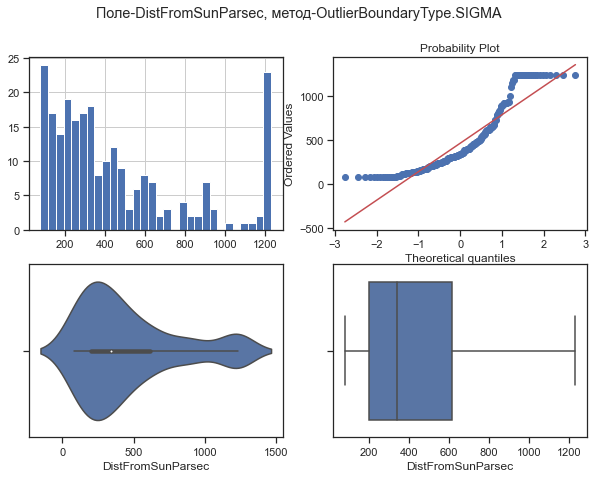

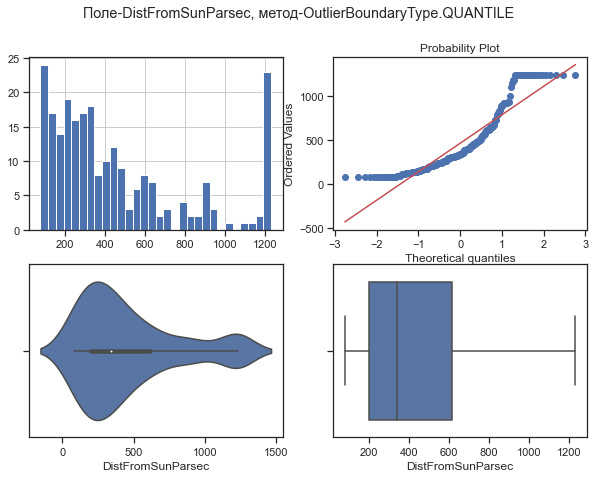

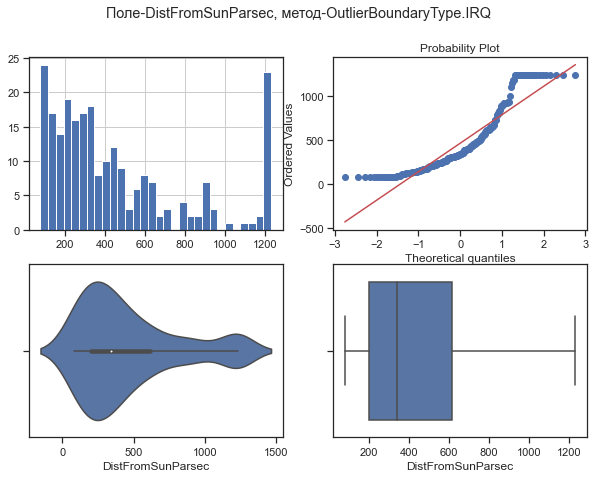

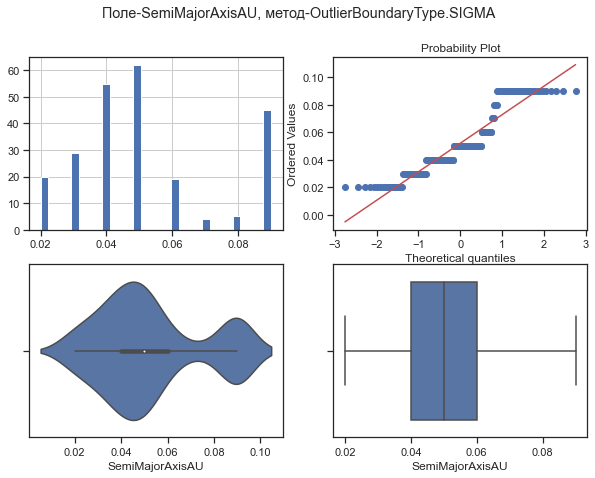

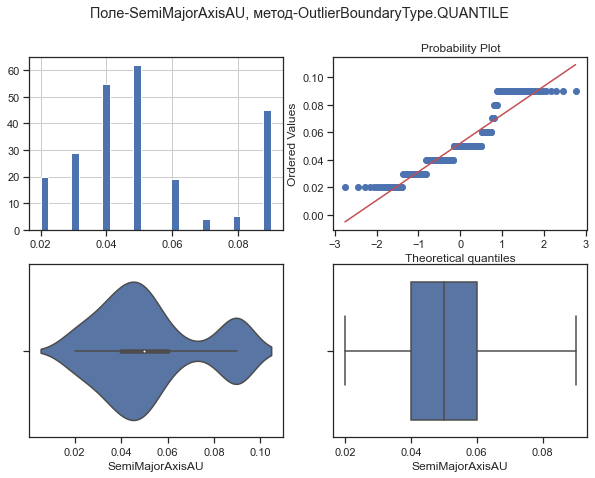

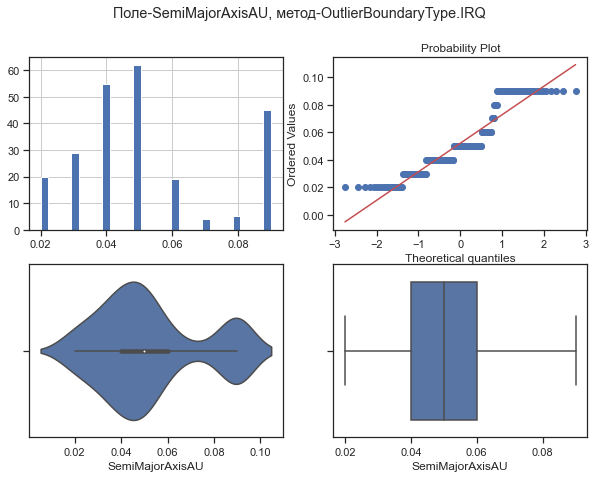

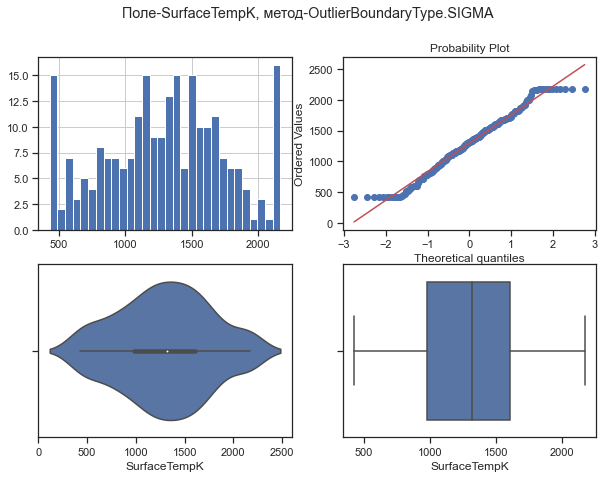

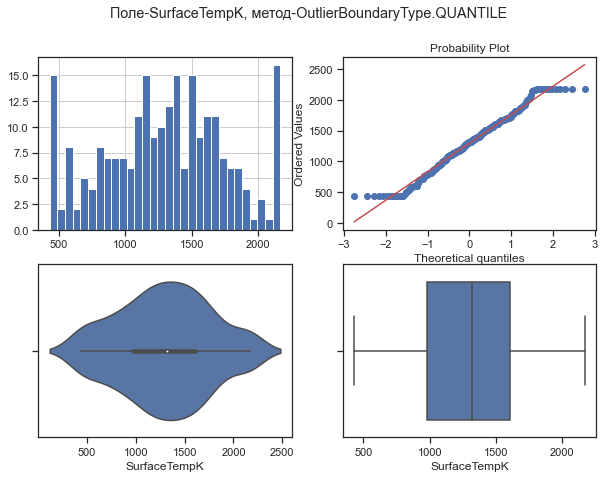

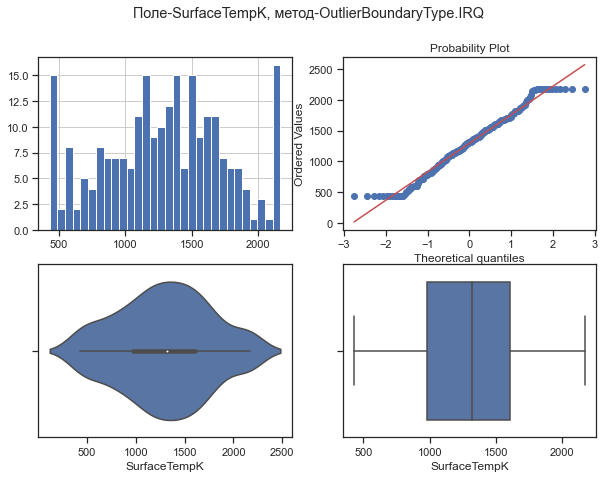

In [82]:
for col in x_col_list:    
    for obt in OutlierBoundaryType:
        # Вычисление верхней и нижней границы
        lower_boundary, upper_boundary = get_outlier_boundaries(data, col, obt)
        # Изменение данных
        data1[col] = np.where(data[col] > upper_boundary, upper_boundary, 
                                 np.where(data[col] < lower_boundary, lower_boundary, data[col]))
        title = 'Поле-{}, метод-{}'.format(col, obt)
        diagnostic_plots(data1, col, title)

In [88]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler 

In [90]:
sc = StandardScaler()
data1_sc = sc.fit_transform(x)
data1=arr_to_df(data1_sc)

In [92]:
automl1= AutoML()
automl1.fit(data1, data['Type'])

AutoML directory: AutoML_3
The task is multiclass_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline logloss 0.993422 trained in 0.18 seconds
2_DecisionTree logloss 0.739275 trained in 12.59 seconds
3_Linear logloss 0.766762 trained in 5.56 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost logloss 0.506169 trained in 5.18 seconds
5_Default_NeuralNetwork logloss 0.911945 trained in 0.54 seconds
6_Default_RandomForest logloss 0.515012 trained in 9.78 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.488841 trained in 0.17 seconds
AutoML fit time: 39.1 seconds


AutoML()